d:\Users\arnab\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2/2 [==============================] - 0s 5ms/step
Epoch: 0 	 Discriminator Loss: 0.6952033340930939 	 Generator Loss: 0.6920560598373413
2/2 [==============================] - 0s 5ms/step
Epoch: 100 	 Discriminator Loss: 0.08582422509789467 	 Generator Loss: 3.393887519836426
2/2 [==============================] - 0s 6ms/step
Epoch: 200 	 Discriminator Loss: 0.3110651522874832 	 Generator Loss: 2.2626020908355713
2/2 [==============================] - 0s 5ms/step
Epoch: 300 	 Discriminator Loss: 0.6067511737346649 	 Generator Loss: 1.8196797370910645
2/2 [==============================] - 0s 5ms/step
Epoch: 400 	 Discriminator Loss: 0.6108447909355164 	 Generator Loss: 1.361830234527588
2/2 [==============================] - 0s 6ms/step
Epoch: 500 	 Discriminator Loss: 0.5470723807811737 	 Generator Loss: 1.467789888381958
2/2 [==============================] - 0s 5ms/step
Epoch: 600 	 Discriminator Loss: 0.6831684410572052 	 Generator Loss: 1.2934142351150513
2/2 [===================

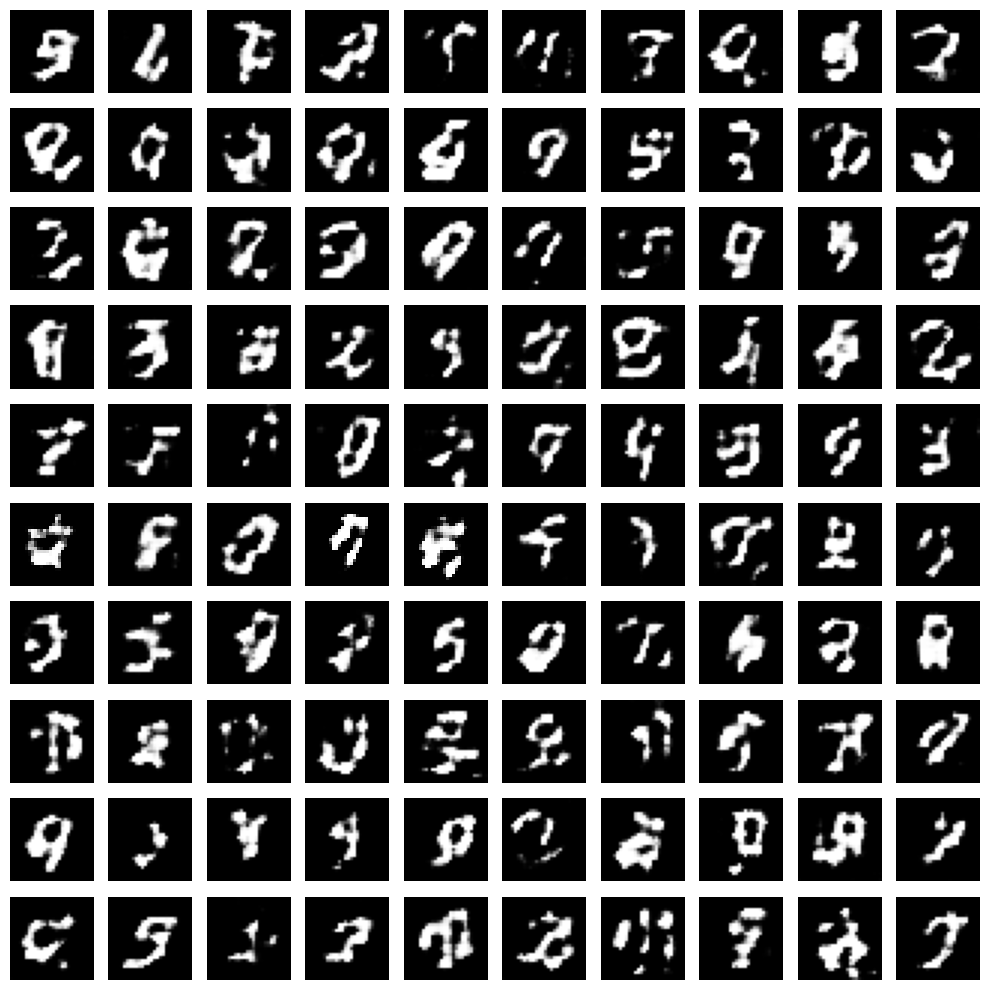

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU
from keras.optimizers import Adam
from keras.datasets import mnist

# Load MNIST data
# (X_train, ), (X_test, _) = mnist.load_data()
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Normalize data
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

# Define generator
def build_generator():
    model = Sequential()
    model.add(Dense(7 * 7 * 128, input_dim=100))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', activation='tanh'))
    return model

# Define discriminator
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Compile discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

# Combine generator and discriminator into a single model
generator = build_generator()
z = Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)
gan = Model(z, validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Train DCGAN
epochs = 1000
batch_size = 64
for epoch in range(epochs):
    # Select a random batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_images = X_train[idx]

    # Generate fake images
    noise = np.random.normal(0, 1, (batch_size, 100))
    fake_images = generator.predict(noise)

    # Train discriminator
    d_loss_real = discriminator.train_on_batch(real_images, np.ones(batch_size))
    d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros(batch_size))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = gan.train_on_batch(noise, np.ones(batch_size))

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} \t Discriminator Loss: {d_loss[0]} \t Generator Loss: {g_loss}")

# Generate images
noise = np.random.normal(0, 1, (100, 100))
generated_images = generator.predict(noise)

# Display generated images
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()